# Imports

In [6]:
# Project setup and imports
import os, sys, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from svgutils.compose import Figure, Panel, SVG
import pickle
from matplotlib import colors as mcolors
from scipy.signal import savgol_filter

# Locate project root and add to path
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'src').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project-specific imports
from src.simulation import SR_sim
from src.plotting import SR_plotting
import src.sr_utils as utils
import src.correlation_analysis as ca
import src.twin_analysis as ta
import src.gamma_gompertz as gg
from src.HMD_lifetables import HMD
import saved_results.twin_studies_data as td
import saved_results.model_param_calibrations as pc

# Reproducibility setup
SEED = int(os.environ.get('PYTHONHASHSEED', '12345'))
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
RNG = np.random.default_rng(12345)

# Deterministic sampling helpers
def choice_deterministic(a, size=None, replace=True, p=None):
    return RNG.choice(a, size=size, replace=replace, p=p)

def rand_uniform(size=None):
    return RNG.random(size)

# Matplotlib configuration
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot styling
plt.rc('axes', facecolor='white', grid=False)
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=16)
plt.rc('axes', titlesize=28, labelsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick.major', size=8, width=2.5)
plt.rc('ytick.major', size=8, width=2.5)
plt.rc('xtick.minor', size=5, width=2.5)
plt.rc('ytick.minor', size=5, width=2.5)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=28)

def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Jupyter extensions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
sr_path = os.path.join(PROJECT_ROOT, 'saved_results')

with open(os.path.join(sr_path, 'danish_GG_correlation_matrices.pkl'), 'rb') as f:
    danish_gg_correlation_matrices = pickle.load(f)
with open(os.path.join(sr_path, 'danish_SR_correlation_matrices.pkl'), 'rb') as f:
    danish_sr_correlation_matrices = pickle.load(f)


with open(os.path.join(sr_path, 'swedish_GG_correlation_matrices.pkl'), 'rb') as f:
    swedish_gg_correlation_matrices = pickle.load(f)
with open(os.path.join(sr_path, 'swedish_SR_correlation_matrices.pkl'), 'rb') as f:
    swedish_sr_correlation_matrices = pickle.load(f)


## Functions

In [8]:
# Helper functions

h2_danish = 0.23
h2_std_danish = 0.03
h2_swedish = 0.34
h2_std_swedish = 0.015

h_exts = pc.h_exts
filtered_ages = pc.filtered_ages


def smooth_and_extend(data, window_size=3, target_length=None):
    """Smooth data and extend with linear extrapolation, optionally to a target length"""
    if len(data) <= window_size:
        if target_length and len(data) != target_length:
            # If target length specified and different, interpolate to match
            x_old = np.arange(len(data))
            x_new = np.linspace(0, len(data)-1, target_length)
            return np.interp(x_new, x_old, data)
        return data
        
    # Padding and smoothing
    pad_width = window_size // 2
    y_padded = np.pad(data, (pad_width, pad_width), mode='edge')
    smoothed = np.convolve(y_padded, np.ones(window_size)/window_size, mode='valid')
    
    # Linear extension
    last_valid_idx = np.where(~np.isnan(smoothed))[0][-1]
    last_valid = smoothed[last_valid_idx]
    slope = smoothed[last_valid_idx] - smoothed[last_valid_idx - 1]
    num_points = len(smoothed) - last_valid_idx - 1
    extension = np.array([last_valid + slope * (i+1) for i in range(num_points)])
    
    result = np.concatenate([smoothed[:last_valid_idx + 1], extension])
    
    # If target length specified, interpolate to match
    if target_length and len(result) != target_length:
        x_old = np.linspace(0, 1, len(result))
        x_new = np.linspace(0, 1, target_length)
        result = np.interp(x_new, x_old, result)
    
    return result

def plot_corrs_vs_mex(plot_type='h2', study='danish', filter_age=15, 
                      use_both=True, models=['gg', 'sr'], 
                      color_dict={'gg': 'green', 'sr': 'purple'},
                      window_size=1, country_fits=None,
                      ax=None, use_paper_values=True):
    """
    Plot twin correlations/heritability vs extrinsic mortality rate (mex)
    
    Parameters:
    plot_type : 'mz', 'dz', or 'h2'
    study : 'danish' or 'swedish'
    filter_age : age cutoff to use for filtering (15, 37, etc.)
    use_both : whether to plot combined genders (True) or separate (False)
    models : list of models to plot ('gg', 'sr', etc.)
    color_dict : color mapping for models
    window_size : size of window for smoothing data
    country_fits : if specified, use this country's model fits instead of study country
    ax : matplotlib axis to plot on (if None, creates new figure/axis)
    use_paper_values : if True, use h2 values from paper instead of calculated values
    """
    if ax is None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
    
    # Get study data
    if study.lower() == 'danish':
        study_data = td.get_study_data('herskind')
        title_country = 'Danish'
        study_name = 'Herskind et al, 1996'
        years_range = '1870-1900'
        default_age = 15
        paper_h2 = h2_danish
        paper_h2_std = h2_std_danish
    elif study.lower() == 'swedish':
        study_data = td.get_study_data('ljinquist')
        study_name = 'Ljinquist et al, 1998'
        title_country = 'Swedish'
        years_range = '1886-1925'
        default_age = 37
        paper_h2 = h2_swedish
        paper_h2_std = h2_std_swedish
    else:
        raise ValueError("Study must be 'danish' or 'swedish'")

    # Get mex estimates and compute asymmetric error bars
    mex = study_data['metadata']['mex']
    mex_lower = study_data['metadata']['mex_lower']
    mex_upper = study_data['metadata']['mex_upper']
    # Create asymmetric error bars: [[lower_error], [upper_error]]
    mex_err = [[mex - mex_lower], [mex_upper - mex]]
    
    # Find age index in filtered ages
    age_index = np.where(filtered_ages == filter_age)[0][0]
    
    # Plot model predictions
    for model in models:
        # Use country_fits if specified, otherwise use study country
        country = country_fits if country_fits else study.lower()
        
        # Get the appropriate correlation matrix based on country and model
        if country == 'danish':
            if model == 'gg':
                matrix = danish_gg_correlation_matrices
            elif model == 'sr':
                matrix = danish_sr_correlation_matrices
        elif country == 'swedish':
            if model == 'gg':
                matrix = swedish_gg_correlation_matrices
            elif model == 'sr':
                matrix = swedish_sr_correlation_matrices
        
        if plot_type == 'h2':
            mean = matrix['h2_std'][age_index,:]
            lower = matrix['h2_lower'][age_index,:]
            upper = matrix['h2_upper'][age_index,:]
        else:
            # For MZ and DZ correlations, use the correct keys
            mean = matrix[plot_type][age_index,:]
            lower = matrix[f'{plot_type}_lower'][age_index,:]
            upper = matrix[f'{plot_type}_upper'][age_index,:]
        
        # Smooth and extend predictions, ensuring same length as h_exts
        target_length = len(h_exts)
        smoothed_mean = smooth_and_extend(mean, window_size, target_length)
        smoothed_lower = smooth_and_extend(lower, window_size, target_length)
        smoothed_upper = smooth_and_extend(upper, window_size, target_length)
        
        ax.fill_between(h_exts, smoothed_lower, smoothed_upper, 
                        color=color_dict[model], alpha=0.2, edgecolor='none')
        ax.plot(h_exts, smoothed_mean, color=color_dict[model], 
                linewidth=4, label=f'{"MGG" if model=="gg" else model.upper()} model predictions')

    # Plot empirical data
    if plot_type == 'h2':
        if use_paper_values:
            # Use values from paper
            corr = paper_h2
            corr_se = paper_h2_std
        else:
            if use_both:
                corr = study_data['combined']['h2']['all']
                corr_se = study_data['combined']['h2']['all_se']
            else:
                corr = study_data['combined']['h2']['male' if study=='swedish' else 'males']
                corr_se = study_data['combined']['h2']['male_se' if study=='swedish' else 'males_se']
    else:
        if use_both:
            key = f'all_{plot_type.upper()}'
            corr = study_data['combined'][key]['r']
            corr_se = (study_data['combined'][key]['std_1'][1] - 
                      study_data['combined'][key]['std_1'][0])/2
        else:
            corr = []
            for gender, color, marker in [('male', 'blue', '^'), ('female', 'red', 'o')]:
                key = f'{gender}_{plot_type.upper()}'
                gender_corr = study_data['combined'][key]['r']
                gender_se = (study_data['combined'][key]['std_1'][1] -
                            study_data['combined'][key]['std_1'][0])/2
                
                ax.errorbar(mex, gender_corr, xerr=mex_err, yerr=gender_se,
                           color=color, marker=marker, markersize=15,
                           markerfacecolor='white', markeredgecolor=color, markeredgewidth=2,
                           capsize=5, capthick=1, label=f'{title_country} {plot_type.upper()} {gender.title()}s')

    if use_both:
        # Plot combined data
        if use_paper_values:
            # Plot paper values with asymmetric error bars
            ax.errorbar(mex, corr, xerr=mex_err, yerr=corr_se,
                       color='black', marker='o', markersize=15,
                       markerfacecolor='black', markeredgecolor='black', markeredgewidth=1,
                       capsize=5, capthick=1, label=f'{title_country} twins\nborn {years_range}')
        else:
            ax.errorbar(mex, corr, xerr=mex_err, yerr=corr_se,
                       color='black', marker='o', markersize=15,
                       markerfacecolor='black', markeredgecolor='black', markeredgewidth=1,
                       capsize=5, capthick=1, label=f'{title_country} {r"$h^2$ Heritability" if plot_type=="h2" else plot_type.upper()}\n({years_range})')

    # Configure axes
    ax.set_xscale('log')
    ax.set_xlim(1e-6, 1e-2)
    ax.set_xlabel(r'$m_{ex}$  extrinsic mortality [year$^{-1}$]', fontsize=24, fontfamily='Arial')
    
    if plot_type == 'h2':
        ax.set_ylim(bottom=0.1, top=0.8)
        ax.set_ylabel('Heritability', fontsize=24, fontfamily='Arial')
        title_suffix = 'Heritability'
    else:
        if plot_type == 'mz':
            ax.set_ylim(bottom=0.1, top=0.65)
        else:
            ax.set_ylim(bottom=0.03, top=0.33)
        ax.set_ylabel(f'$r_{{{plot_type.upper()}}}$  {plot_type.upper()} lifespan correlations', fontsize=24, fontfamily='Arial')
        title_suffix = f'{plot_type.upper()} Correlations'

    ax.tick_params(axis='both', which='major', labelsize=16, width=2.5, length=8)
    ax.tick_params(axis='both', which='minor', width=2.5, length=5)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Arial')
    
    ax.legend(fontsize=16, loc='upper left', prop={'family': 'Arial'})
    
    ax.set_title(f'{title_country} twin cohort', fontsize=30, pad=20, fontfamily='Arial')
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    return ax


#  Fig2

In [9]:
# Import calibrations

n = 5000
filter_age = 15

# Get Denmark calibration parameters
denmark_calibs = pc.sr_calibrations['denmark']

# Create parameter distribution using calibrated values
dict = utils.create_param_distribution_dict(params='Xc', std=denmark_calibs['Xc_std'], n=n, family='MZ')
dict['eta'] = denmark_calibs['eta_factor'] * dict['eta']
dict['beta'] = denmark_calibs['beta_factor'] * dict['beta']

# Create simulations
denmark_male_sim_no_ext = utils.create_sr_simulation(n=n, params_dict=dict, parallel=False, h_ext=1e-30)
denmark_male_sim_with_h_ext = utils.create_sr_simulation(n=n, params_dict=dict, parallel=False, h_ext=denmark_calibs['m_ex'])

# Calculate twin death tables
twin_table_no_extrinsic = ta.calc_twin_death_table(denmark_male_sim_no_ext, filter_age=filter_age)
twin_table_with_extrinsic = ta.calc_twin_death_table(denmark_male_sim_with_h_ext, filter_age=filter_age)


Text(-0.1, 1.1, 'D')

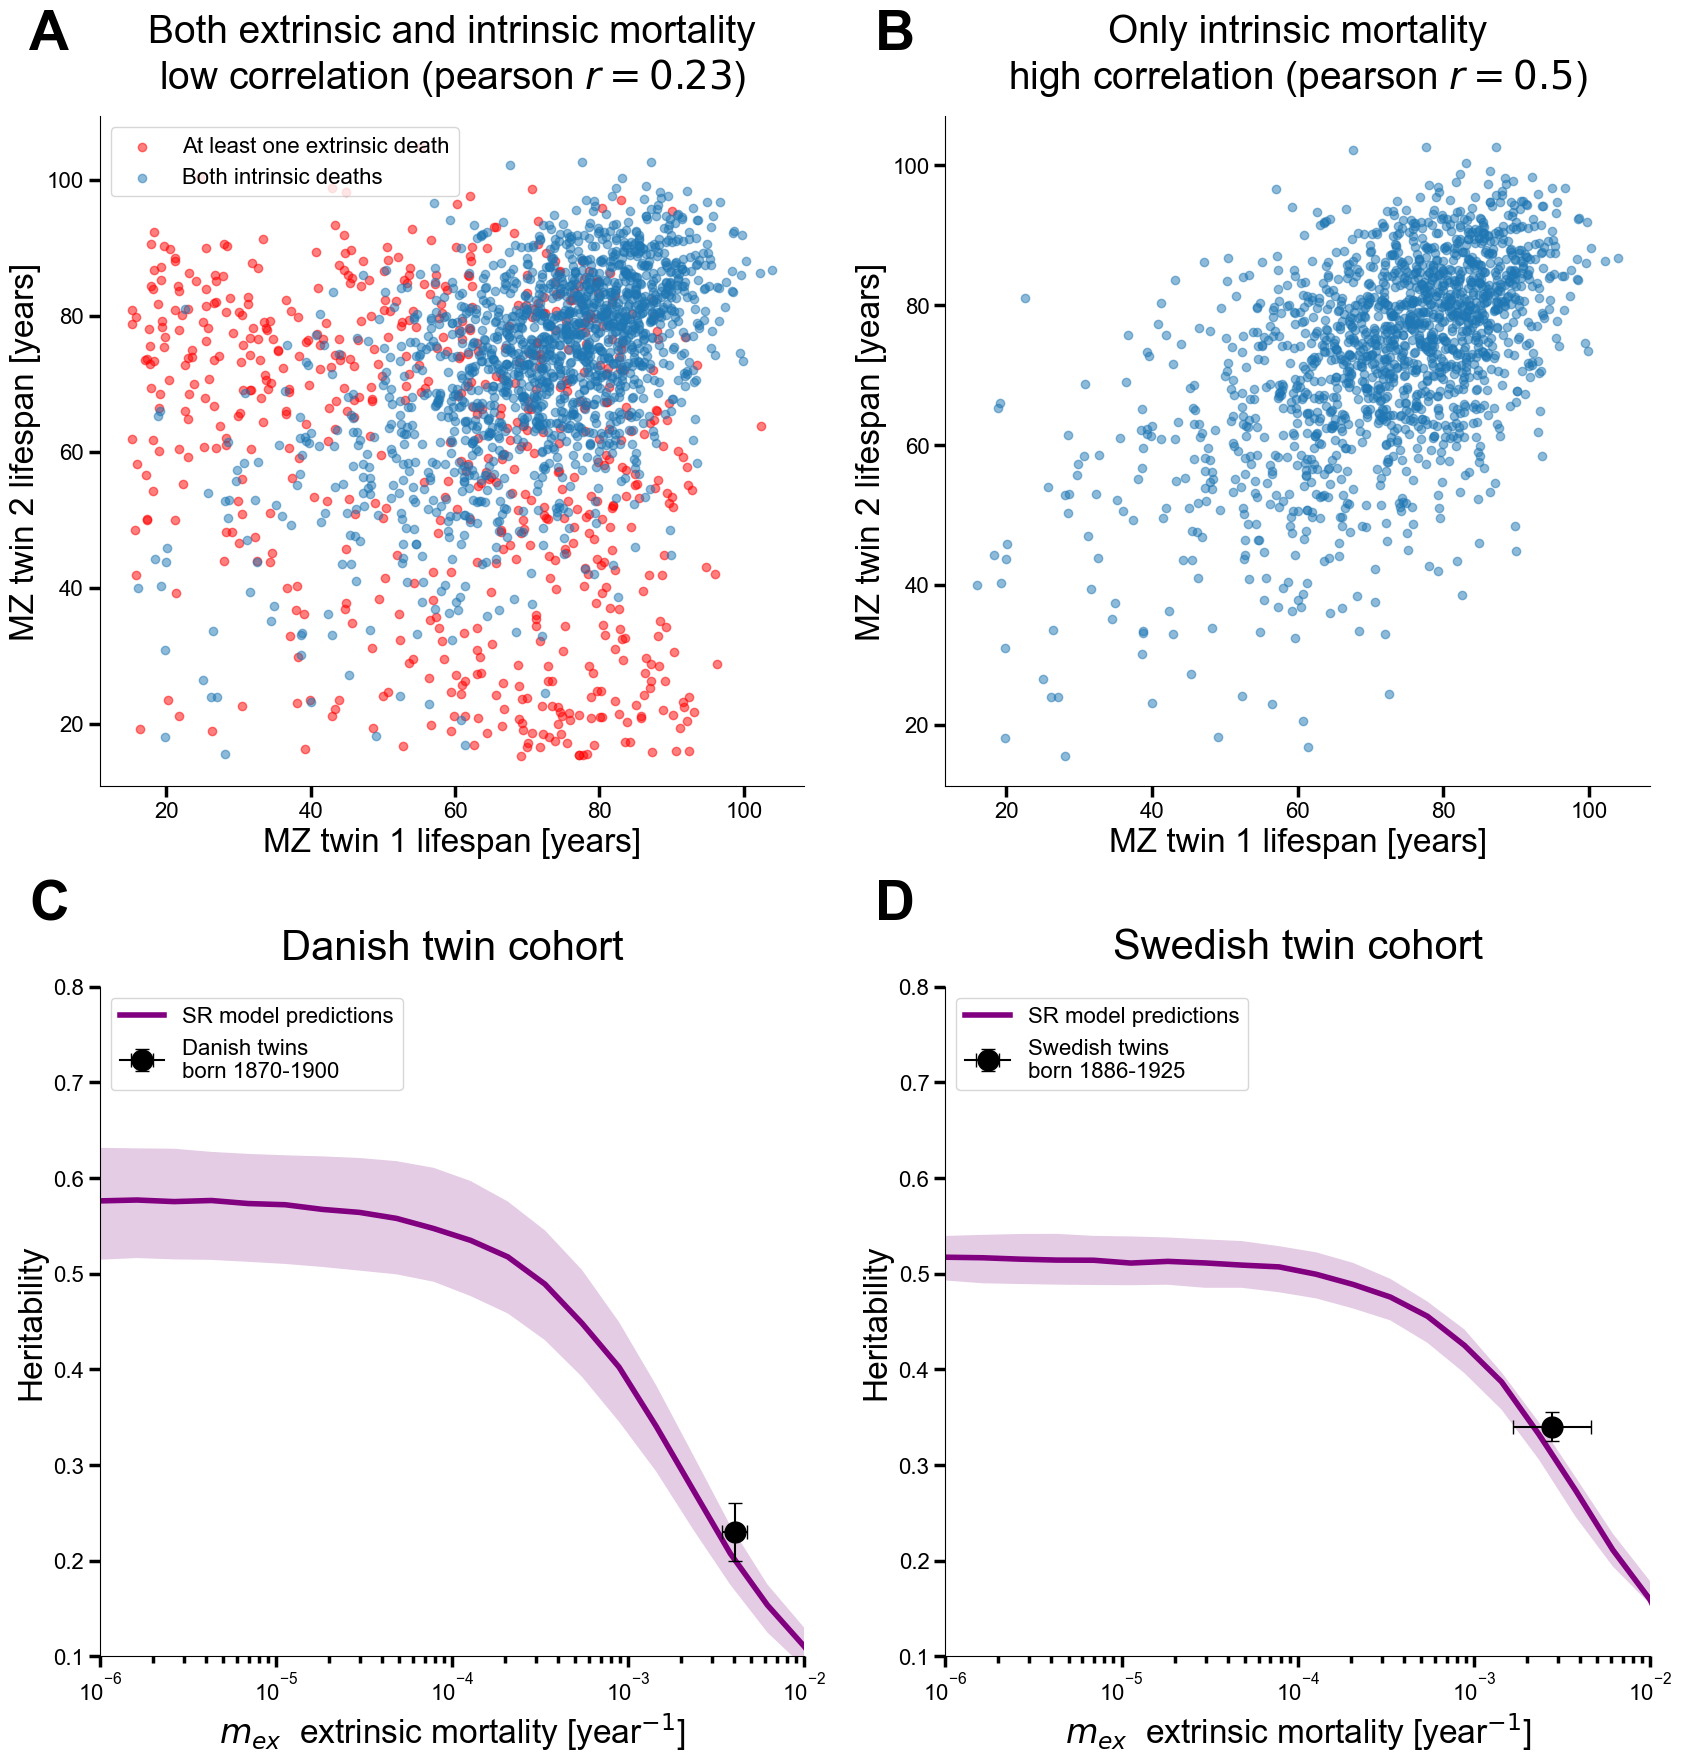

In [10]:
# Create figure and subplots using plt.subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20), height_ratios=[1, 1], gridspec_kw={'hspace': 0.3})

# Left plot - with extrinsic mortality
extrinsic_deaths = twin_table_with_extrinsic[
    (twin_table_with_extrinsic['death1_extrinsic']) | 
    (twin_table_with_extrinsic['death2_extrinsic'])
]
intrinsic_deaths = twin_table_with_extrinsic[
    (~twin_table_with_extrinsic['death1_extrinsic']) & 
    (~twin_table_with_extrinsic['death2_extrinsic'])
]

ax1.scatter(extrinsic_deaths['death1'],
            extrinsic_deaths['death2'],
            alpha=0.5,
            color='red',
            label='At least one extrinsic death')

ax1.scatter(intrinsic_deaths['death1'], 
            intrinsic_deaths['death2'],
            alpha=0.5,
            label='Both intrinsic deaths')

# Right plot - no extrinsic mortality
ax2.scatter(intrinsic_deaths['death1'], intrinsic_deaths['death2'], alpha=0.5)

# Set titles and configure axes
fontsize = 28
for a in [ax1, ax2, ax3, ax4]:
    a.tick_params(axis='both', which='major', labelsize=16, width=2.5, length=8)
    a.tick_params(axis='both', which='minor', width=2.5, length=5)
    
ax1.set_xlabel('MZ twin 1 lifespan [years]', fontsize=24)
ax1.set_ylabel('MZ twin 2 lifespan [years]', fontsize=24)
ax1.set_title(r'Both extrinsic and intrinsic mortality' + '\n' + r'low correlation (pearson $r=0.23$)',
              fontsize=fontsize, pad=20)
ax1.legend(loc='upper left', fontsize=16)

ax2.set_xlabel('MZ twin 1 lifespan [years]', fontsize=24)
ax2.set_ylabel('MZ twin 2 lifespan [years]', fontsize=24)
ax2.set_title(r'Only intrinsic mortality' + '\n' + r'high correlation (pearson $r=0.5$)', fontsize=fontsize, pad=20)


plot_corrs_vs_mex(plot_type='h2', study='danish', models = ['sr'] , filter_age=15, use_both=True, ax=ax3, window_size=5)

plot_corrs_vs_mex(plot_type='h2', study='swedish', models = ['sr']  , filter_age=37, use_both=True, ax=ax4, window_size=5)


# Add subplot labels (a), (b), (c), and (d)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, 
         fontsize=40, fontweight='bold', fontname='Arial')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, 
         fontsize=40, fontweight='bold', fontname='Arial')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, 
         fontsize=40, fontweight='bold', fontname='Arial')
ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, 
         fontsize=40, fontweight='bold', fontname='Arial')


